# this code does not append pipelines without routes (it skips them)

In [30]:
import pygsheets # use 'pip install pygsheets'
import numpy
import datetime

import pandas
import geopandas
#import geopandas.tools import overlay
import pathlib

import shapely

In [31]:
gc = pygsheets.authorize(service_account_env_var='GDRIVE_API_CREDENTIALS')
spreadsheet = gc.open_by_key('1foPLE6K-uqFlaYgLPAUxzeXfDO5wOOqE7tibNHeqTek')

gas_pipes = spreadsheet.worksheet('title', 'Gas pipelines').get_as_df(start='A3')
oil_pipes = spreadsheet.worksheet('title', 'Oil/NGL pipelines').get_as_df(start='A3')

#gas_pipes.drop('WKTFormat', axis=1, inplace=True) # delete WKTFormat column
#oil_pipes.drop('WKTFormat', axis=1, inplace=True)

# delete columns that aren't the same in the sheets, to concatenate them...
columns_not_in_oil = list(set(gas_pipes.columns)-set(oil_pipes.columns))
columns_not_in_gas = list(set(oil_pipes.columns)-set(gas_pipes.columns))
gas_pipes.drop(columns=columns_not_in_oil, axis=1, inplace=True)
oil_pipes.drop(columns=columns_not_in_gas, axis=1, inplace=True)

# define whether you want just oil, just gas, or both

In [32]:
#fuel_type = 'oil'
#fuel_type = 'gas'
fuel_type = 'oil-and-gas'

if fuel_type=='oil':
    pipes_orig = oil_pipes
    #pipe.drop(column='CapacityBOEd', inplace=True)
elif fuel_type=='gas':
    pipes_orig = gas_pipes
    #pipe.drop('CapacityBcm/y', inplace=True)
elif fuel_type=='oil-and-gas':  
    pipes_orig = pandas.concat([oil_pipes, gas_pipes], ignore_index=True)

pipes_orig.replace('--', numpy.nan, inplace=True)

In [33]:
# clean up column 'Route'
pipes_orig['Route'] = pipes_orig['Route'].str.strip()

pipes_noroute_df = pipes_orig.loc[pipes_orig.RouteAccuracy=='no route']
pipes_withroute_df = pipes_orig.loc[pipes_orig.RouteAccuracy!='no route']

In [34]:
def convert_gfit_to_linestring(coord_str, pipeline_name, segment_name):
    '''
    Takes string from GFIT column of coordinates for a single pipeline,
    converts that string into Shapely LineString or MultiLinestring.
    '''
    #print(pipeline_name, segment_name)
    
    if ':' in coord_str and ';' not in coord_str:
        # simple geometry; no branching
        # create nested list of lists, separating on colons        
        coord_list = coord_str.split(':')
        coord_list_tuples = []
        # non-branched pipeline (nested list with one level)
        # convert nested list of lists to list of tuples
        try:
            for element in coord_list:
                element_tuple = (float(element.split(',')[1]), 
                                 float(element.split(',')[0]))
                coord_list_tuples.append(element_tuple)
        except:
            print(f"Exception for {pipeline_name}; {segment_name}; element: {element}") # for db
        route_conv = shapely.geometry.LineString(coord_list_tuples)

    elif ':' in coord_str and ';' in coord_str:
        # create a nested list of lists, separating on semicolons
        coord_list = coord_str.split(';')   
        # create a second level of nesting, separating on colons
        coord_list = [x.split(':') for x in coord_list]
        # branched pipeline (nested list with two levels)
        route_conv_list_all = []
        
        for nested_list in coord_list:
            coord_list_tuples = []
            # process element
            try:
                for element in nested_list:
                    element_tuple = (float(element.split(',')[1]), 
                                     float(element.split(',')[0]))
                    coord_list_tuples.append(element_tuple)
            except:
                print(f"Exception for {pipeline_name}; segment {segment_name}; element: {element}") # for db
            # process coord_list_tuples
            try:
                route_conv_list = shapely.geometry.LineString(coord_list_tuples)
                route_conv_list_all.append(route_conv_list)
            except:
                print(f"Exception for {pipeline_name}; coord_list_tuples: {coord_list_tuples}") # for db
                pass
        
        route_conv = shapely.geometry.MultiLineString(route_conv_list_all)
        
    return route_conv

In [35]:
def convert_all_pipelines(df):
    """
    Apply the conversion function to all pipelines in the dataframe.
    """
    # create geometry column with empty strings
    df['geometry'] = ''
    
    # filter to keep only pipelines with routes
    mask_route = df['Route'].str.contains(',' or ':')
    pipes_with_route = df.loc[mask_route]
    
    for row in pipes_with_route.index:
        route_str = df.at[row, 'Route']
        pipeline_name = df.at[row, 'PipelineName']
        segment_name = df.at[row, 'SegmentName']
        route_str_converted = convert_gfit_to_linestring(route_str, pipeline_name, segment_name)
        df.at[row, 'geometry'] = route_str_converted
    
    return df

In [36]:
# code to create a dataframe with WKT formatted geometry

# (1) copy gas_pipelines, clean up
to_convert = pipes_orig.copy()#.loc[pipes_orig.Route!='']

# (2) convert all pipelines
pipes_wkt_df = convert_all_pipelines(to_convert)
pipes_wkt_df = pipes_wkt_df.reset_index(drop=True)
pipes_wkt_df = pipes_wkt_df.replace({'geometry':''},{'geometry':None})
#pipes_wkt_df = pipes_wkt_df.loc[pipes_wkt_df.geometry!=''] # remove anything that's not a geometry...

# (3) store in a GeoDataFrame, attach a projection, transform to a different one
#pipes_wkt_df['geometry'] = pipes_wkt_df['geometry'].apply(shapely.wkt.loads)
pipes_gdf = geopandas.GeoDataFrame(pipes_wkt_df, geometry=pipes_wkt_df['geometry'])
#pipes_gdf = pipes_gdf.set_crs('epsg:4326')
#pipe_gdf_4087 = pipes_wkt_gdf.to_crs('epsg:4087')

pipes_gdf = pipes_gdf.sort_values('ProjectID')

<Axes: >

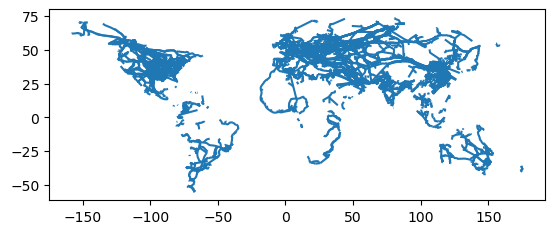

In [37]:
pipes_gdf.geometry.plot()

# save geodataframe as Excel file with just ProjectID, geometry

In [38]:
pipes_gdf[['ProjectID','geometry']]

,ProjectID,geometry
848,P0001,"LINESTRING (-111.31072 52.66972, -109.13337 51..."
887,P0002,"LINESTRING (-113.34182 53.57294, -112.91198 53..."
778,P0004,"LINESTRING (-101.73614 48.31197, -102.26074 48..."
890,P0005,"LINESTRING (-113.20655 53.71175, -95.09766 45...."
682,P0006,"LINESTRING (-87.51366 41.58361, -90.13184 38.8..."
...,...,...
1580,P6396,None
1581,P6397,None
1582,P6398,None
1583,P6399,None


# now import geojson routes

In [39]:
geojson_route_files = list(
    pathlib.Path(
        '/Users/baird/Google Drive/Shared drives/GEM Shared Drive/Programs/Oil & Gas Program/Global Oil and Gas Infrastructure Trackers (GOIT, GGIT)/Data - geojson files/'
    ).rglob('*.geojson')
)

In [40]:
# note as of Feb 2024 geopandas doesn't allow you to read in point values, 
# every geometry type must be linestring or multilinestring. Some of the routes Clay is
# making have valves in the pipelines on OSM, which are points, so there needs to be a
# workaround that lets geopandas open the files and read them properly
# https://github.com/geopandas/geopandas/issues/2962
for file in geojson_route_files:
    project_id = str(file).split('/')[-1][:-8]
    #print(project_id)
    if project_id in ['P0024','P0057']:
        continue
        #file_df = geopandas.read_file(file, ignore_geometry=True)
        #pipeline_location = file_df.loc[file_df.man_made=='pipeline'].index[0]
        #file_gdf = geopandas.read_file(file, rows=slice(pipeline_location,pipeline_location+1))       
    else:
        file_gdf = geopandas.read_file(file)
    file_geometry_dissolved = file_gdf.dissolve().geometry

    pipes_gdf.loc[pipes_gdf.ProjectID==project_id,'geometry'] = file_geometry_dissolved[0]
    
    #print(file_geometry_dissolved)
    #print(project_id)
    #print()
#geopandas.read_file(geojson_route_files[0]).dissolve().geometry

<Axes: >

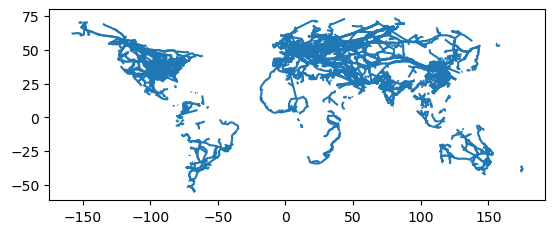

In [41]:
pipes_gdf.geometry.plot()

# TOO LONG, WILL NOT BE INCLUDED IN EXCEL SHEET:

In [43]:
pipes_gdf_culled = pipes_gdf.copy()
pipes_gdf_culled = pipes_gdf_culled.loc[pipes_gdf_culled.geometry!=None]

In [44]:
pipes_gdf_culled.shape

(4404, 101)

In [45]:
now_string = datetime.datetime.now().strftime('%Y-%m-%d')
filename = fuel_type+'-routes-wkt-format-'+now_string+'.xlsx'
pipes_gdf_culled[['ProjectID','geometry']].to_excel(filename, index=False)
print('saved as', filename)

saved as oil-and-gas-routes-wkt-format-2024-03-04.xlsx


In [46]:
pipes_gdf.loc[pipes_gdf.Fuel=='Hydrogen']

,PipelineNetworkGrouping,PipelineName,SegmentName,Wiki,ProjectID,Researcher,LastUpdated,Fuel,Fuel [ref],PipelineType,...,Route [ref],OtherEnglishNames,OtherLanguagePrimaryPipelineName,OtherLanguageAlternativePipelineNames,OtherLanguageSegmentName,WKTFormat,AlternateRouteProjectIDs,CostUSDPerKm,CostEuroPerKm,geometry
2874,,Guitiriz-Zamora Gas Pipeline,,https://www.gem.wiki/Guitiriz-Zamora-Adradas_G...,P2477,HH,2022-06-30,Hydrogen,,,...,,,,,,NaN,,NaN,NaN,None
4038,,HyDeal España Pipeline,Internal Hydrogen Infrastructure in Spain,https://www.gem.wiki/HyDeal_Espa%C3%B1a_Pipeline,P4383,BL,2024-01-26,Hydrogen,https://www.hydeal.com/copie-de-hydeal-ambition,transmission,...,https://ehb.eu/page/european-hydrogen-backbone...,,,,,NaN,,NaN,NaN,"MULTILINESTRING ((-5.69421 42.56485, -5.69482 ..."
4039,,Lussagnet–Bayonne Gas Pipeline,Hydrogen Ready Expansion,https://www.gem.wiki/Lussagnet%E2%80%93Bayonne...,P4387,HH,2022-10-04,Hydrogen,,,...,,,,,,NaN,,NaN,NaN,None
4040,,Le Havre–Paris Gas Pipeline,Hydrogen Ready Expansion,https://www.gem.wiki/Le_Havre%E2%80%93Paris_Ga...,P4388,HH,2022-10-04,Hydrogen,,,...,,,,,,NaN,,NaN,NaN,None
4041,,Hauts de France II Gas Pipeline,Hydrogen Ready Expansion,https://www.gem.wiki/Hauts_de_France_II_Gas_Pi...,P4389,HH,2022-10-04,Hydrogen,,,...,,,,,,NaN,,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5347,,UK Hydrogen Backbone,,,P6223,BL,2024-02-07,Hydrogen,https://www.h2inframap.eu/,transmission,...,"https://www.h2inframap.eu/, https://ehb.eu/",,Project Union,,,NaN,,NaN,NaN,"MULTILINESTRING ((-1.80611 57.58025, -1.81263 ..."
5348,,European Hydrogen Backbone,2030 Infrastructure Not on PCI6,,P6224,BL,2024-02-11,Hydrogen,https://ehb.eu/page/european-hydrogen-backbone...,transmission,...,https://ehb.eu/page/european-hydrogen-backbone...,,,,,NaN,,NaN,NaN,"MULTILINESTRING ((7.21324 53.17442, 7.24797 53..."
5349,,Franco-Belgian H2 Corridor,WHYNN Phase 2 and 3,,P6225,BL,2024-02-14,Hydrogen,https://www.grtgaz.com/en/our-energy-transitio...,transmission,...,,,,,,NaN,,NaN,NaN,None
5351,,RHYn Pipeline,Phase 3 – Fessenheim -Marckolsheim,https://www.gem.wiki/RHYn_Pipeline,P6227,BL,2024-02-17,Hydrogen,https://www.grtgaz.com/en/medias/press-release...,transmission,...,,,,,,NaN,,NaN,NaN,None


In [47]:
now_string = datetime.datetime.now().strftime('%Y-%m-%d')
filename = fuel_type+'-routes-wkt-format-'+now_string+'.csv'
pipes_gdf_culled[['ProjectID','geometry']].to_csv(filename, index=False)
print('saved as', filename)

saved as oil-and-gas-routes-wkt-format-2024-03-04.csv
